<a href="https://colab.research.google.com/github/nilesh3030/Natural-Language-Processing/blob/main/Audio_Classification_multimodal_Nilesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd

excel_file_path = '/content/gdrive/MyDrive/7_KESDy18/SER-DB-ETRIv18_emotion_label_annotation.xlsx'

# Read Excel file into a pandas DataFrame, without using any header
df = pd.read_excel(excel_file_path, header=None)

# Concatenate the first and second rows to create a single header row
header_row = df.iloc[0] + '_' + df.iloc[1].astype(str)
df.columns = header_row

# Drop the first two rows as they are now included in the header
df = df.drop([0, 1])

# Display the DataFrame
print(df.head())

In [ ]:
df.shape

In [ ]:
df['Total Evaluation_Emotion'].value_counts()

We can see that there are few lables which have multiple emotions so for the simplicity of our analysis we will keep only those records which have a single emotion. Also we can see that data is skewed where neural emotion has almost 50% of the records so this is a clear case of imbalanced dataset.

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# Replace 'your_audio.wav' with the actual path to your .wav file
audio_file_path = '/content/gdrive/MyDrive/7_KESDy18/004/dy/angry/004_dy_a_02.wav'

# Load the audio file
y, sr = librosa.load(audio_file_path, sr=None)

# Calculate the time values for x-axis
time = np.arange(0, len(y)) / sr

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# sample rate of the audio file
sr

MFCCs capture the essential spectral characteristics of the audio signal. The first few coefficients often represent the overall spectral shape, while higher-order coefficients capture finer details.

In [ ]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
print(mfccs.shape)

In [ ]:
# Function of extarct the MFCC features
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

extract_features(audio_file_path)

In [ ]:
# root folder containing .wav files
root_folder = '/content/gdrive/MyDrive/7_KESDy18/'

# Create an empty list to store the results
extracted_features=[]

### Now we iterate through every audio file and extract features
### using Mel-Frequency Cepstral Coefficients
for root, dirs, files in os.walk(root_folder):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            # Extract features and add them to the DataFrame
            features = extract_features(file_path)
            extracted_features.append([file,features])

### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['file','features'])
extracted_features_df.head()

In [ ]:
# !pip install googletrans==4.0.0-rc1
# !pip install nltk

In [ ]:
import glob
import googletrans
from googletrans import Translator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
# Function to translate text to English
def translate_to_english(text):
    translator = Translator()
    translation = translator.translate(text, src='auto', dest='en')
    return translation.text

# Function for text preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Stemming
    ps = PorterStemmer()
    stemmed_tokens = [ps.stem(word) for word in filtered_tokens]

    # Join tokens back to text
    preprocessed_text = ' '.join(stemmed_tokens)

    return preprocessed_text

In [ ]:
# List to store file names and preprocessed text
file_names = []
preprocessed_texts = []

# Loop through all text files in the folder
for root, dirs, files in os.walk(root_folder):
    for file_name in files:
        if file_name.endswith(".txt"):
            # Construct the full path to the file
            file_path = os.path.join(root, file_name)

            # Read the text from the file using 'cp949' encoding
            with open(file_path, 'r', encoding='cp949') as file:
                text = file.read()

            # Translate to English
            translated_text = translate_to_english(text)

            # Preprocess the text
            preprocessed_text = preprocess_text(translated_text)

            # Replace the extension with '.wav'
            new_file_name = os.path.splitext(file_name)[0] + '.wav'

            # Append file name and preprocessed text to lists
            file_names.append(new_file_name)
            preprocessed_texts.append(preprocessed_text)

In [ ]:
# Create a DataFrame to store file names and preprocessed texts
df_text = pd.DataFrame({'File_Name': file_names, 'Preprocessed_Text': preprocessed_texts})

In [ ]:
print(df_text.shape)
df_text.head()

In [ ]:
import matplotlib.pyplot as plt

# column containing text
text_data = df_text['Preprocessed_Text']

# Calculate word lengths
word_lengths = text_data.apply(lambda x: len(x.split()))

# Plot histogram
plt.hist(word_lengths, bins=20, color='blue', edgecolor='black')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Histogram of Word Lengths')
plt.show()

We can see most of the text are less than 10 words so we will choose the max length of 10 while doing the padding for the inputs

In [ ]:
# Inner join on different columns
merge_text_label = pd.merge(df_text, df, left_on='File_Name', right_on='Segment ID_nan', how='inner')
final_df = pd.merge(merge_text_label, extracted_features_df, left_on='File_Name', right_on='file', how='inner')
final_df.shape

In [ ]:
final_df.head()

In [ ]:
# Filter only relevant colmuns
model_df = final_df[['features', 'Preprocessed_Text', 'Total Evaluation_Emotion']]

# List of emotions to filter
filter_values = ['neutral', 'sad', 'angry', 'happy', 'surprise', 'disgust', 'fear']

# Filter the DataFrame based on the list of emotions
filter_df = model_df[model_df['Total Evaluation_Emotion'].isin(filter_values)]

In [ ]:
filter_df.shape

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_text_length = 10

def preprocess_data():
    # pad text data
    X_text = filter_df.Preprocessed_Text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_text)

    # Convert text data to integer sequences
    X_text = tokenizer.texts_to_sequences(X_text)
    X_text = np.array(pad_sequences(X_text, maxlen=max_text_length, padding='post').tolist())

    # MFCC features
    mfcc_data = np.array(filter_df.features.tolist())

    # labels
    labels = np.array(filter_df['Total Evaluation_Emotion'].tolist())

    return X_text, mfcc_data, labels

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


# Assuming you have X_text and X_mfcc as your preprocessed text and MFCC features, respectively
X_text, X_mfcc, y = preprocess_data()

# Train-Test split
X_text_train, X_text_test, X_mfcc_train, X_mfcc_test, y_train, y_test = train_test_split(
    X_text, X_mfcc, y, test_size=0.2, random_state=0
)

# Label Encoding
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

In [ ]:
# I have a preprocessed text input and MFCC feature input
text_input = Input(shape=(max_text_length,), name='text_input')
mfcc_input = Input(shape=(40,), name='mfcc_input')

# text processing layers
text_embedding = Embedding(input_dim=2000, output_dim=40)(text_input)
text_flatten = Flatten()(text_embedding)

# MFCC processing layers
mfcc_dense = Dense(100, activation='relu')(mfcc_input)

# Concatenate the processed text and MFCC features
combined = concatenate([text_flatten, mfcc_dense])

# output layer
num_labels = y_train_encoded.shape[1]
output = Dense(num_labels, activation='softmax')(combined)

# Create the model
model = Model(inputs=[text_input, mfcc_input], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Model Checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', verbose=1, save_best_only=True)

# Training
start = datetime.now()
model.fit(
    {'text_input': X_text_train, 'mfcc_input': X_mfcc_train},
    y_train_encoded,
    batch_size=32,
    epochs=200,
    validation_data=({'text_input': X_text_test, 'mfcc_input': X_mfcc_test}, y_test_encoded),
    callbacks=[checkpointer],
    verbose=1
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
# Evaluation
test_accuracy = model.evaluate([X_text_test, X_mfcc_test], y_test_encoded, verbose=0)
print(test_accuracy[1])

# Prediction and Classification Report
y_pred_probabilities = model.predict([X_text_test, X_mfcc_test])
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)
y_true_labels = np.argmax(y_test_encoded, axis=1)
report = classification_report(y_true_labels, y_pred_labels)
print(report)

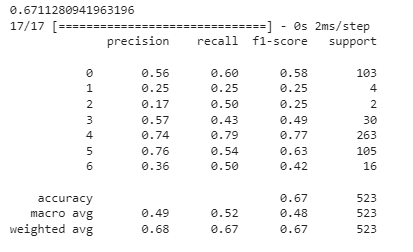



In this result, we should focus on the F1 scores instead of the accuracy. We can see F1 score is reasonable for all the labels but it has higher value for the classes where we had more number of records.

## Another complex model architecture

In [ ]:
# I have a preprocessed text input and MFCC feature input
text_input = Input(shape=(max_text_length,), name='text_input')
mfcc_input = Input(shape=(40,), name='mfcc_input')

# Text processing layers
text_embedding = Embedding(input_dim=2000, output_dim=40)(text_input)
text_flatten = Flatten()(text_embedding)
text_dense_1 = Dense(100, activation='relu')(text_flatten)
text_dense_2 = Dense(50, activation='relu')(text_dense_1)
text_dropout_2 = Dropout(0.5)(text_dense_2)

# MFCC processing layers
mfcc_dense_1 = Dense(100, activation='relu')(mfcc_input)
mfcc_dense_2 = Dense(50, activation='relu')(mfcc_dense_1)
mfcc_dropout_2 = Dropout(0.5)(mfcc_dense_2)

# Concatenate the processed text and MFCC features
combined = concatenate([text_dropout_2, mfcc_dropout_2])

# Additional dense layer with dropout
combined_dense = Dense(200, activation='relu')(combined)
combined_dropout = Dropout(0.2)(combined_dense)

# Output layer
num_labels = y_train_encoded.shape[1]
output = Dense(num_labels, activation='softmax')(combined_dropout)

# Create the model
model_complex = Model(inputs=[text_input, mfcc_input], outputs=output)


# Define custom learning rate
custom_learning_rate = 0.0001  # You can change this value

# Create an instance of the Adam optimizer with the custom learning rate
custom_optimizer = Adam(learning_rate=custom_learning_rate)

# Compile the model
model_complex.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=custom_optimizer)

# Model Checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification_complex.hdf5', verbose=1, save_best_only=True)

# Training
start = datetime.now()
model_complex.fit(
    {'text_input': X_text_train, 'mfcc_input': X_mfcc_train},
    y_train_encoded,
    batch_size=32,
    epochs=500,
    validation_data=({'text_input': X_text_test, 'mfcc_input': X_mfcc_test}, y_test_encoded),
    callbacks=[checkpointer],
    verbose=1
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
# Evaluation
test_accuracy = model_complex.evaluate([X_text_test, X_mfcc_test], y_test_encoded, verbose=0)
print(test_accuracy[1])

# Prediction and Classification Report
y_pred_probabilities = model_complex.predict([X_text_test, X_mfcc_test])
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)
y_true_labels = np.argmax(y_test_encoded, axis=1)
report = classification_report(y_true_labels, y_pred_labels)
print(report)

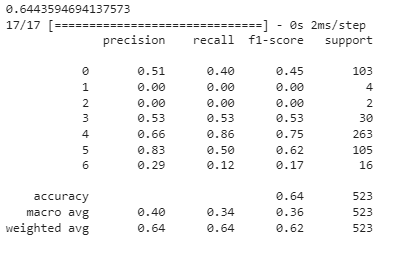


Making a complex model didn't help much as we are short on the tariing dataset so to make a better model we need more records and make the dataset balanced.

## Additional Comments:
- Our model has shown a reasobale perfromanec on a very small set of data. Considering this data was highly imbalanced made it challenging to get a high accuracy or F1 score.
- Additionally we can use the SMOTE techniques to make the dataset balanced and run models on the balanced dataset.
- Since we were dealing with the translation of the korean texts so it would be better if we can use the english texts as the model inputs.
- Regarding the deployment of model, the trained model is not very big so it can be deployed easily.